# NeuroEvolution of Augmenting Topologies (NEAT)
Evolving the weights and the topologies of a Neural Networks using the NEAT algorithm.

In [11]:
import importlib
import environment 
import utils
importlib.reload(environment)
importlib.reload(utils)

import numpy as np
import neat
import matplotlib.pyplot as plt

In [12]:
initial_setting = {
   'agents': np.array([[0, 5], [0, 10], [0, 15]], dtype=float),
   'blocks': np.array([[9, 16], [10, 12], [11, 6]], dtype=float),
   'colors': np.array([environment.RED, environment.GREEN, environment.RED], dtype=int)
}

env = environment.Environment(objective = [(environment.RED, environment.NORTH_EDGE)],
                   size = environment.SIMULATION_ARENA_SIZE, 
                   n_agents = 3, 
                   n_blocks = 3,
                   n_neighbors = 3,
                   sensor_range = environment.SIMULATION_SENSOR_RANGE,
                   sensor_angle = 360,
                   max_distance_covered_per_step = environment.SIMULATION_MAX_DISTANCE,
                   sensitivity = 0.5,
                   initial_setting = initial_setting)
env.reset()
env.print_env()

. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . . . . . . .
. . . . . . . . O . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .


In [ ]:
def calculate_fitnesses_neat(genomes, config, n_steps = 100, verbose=False):
    flag_done = False
    best_steps = n_steps
    
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        obs, _ = env.reset()
        if verbose: env.print_env()

        for step in range(n_steps):
            
            nn_inputs = env.process_observation(obs)
            
            nn_outputs = [net.activate(nn_input) for nn_input in nn_inputs]

            actions = np.round(nn_outputs * np.array([env.max_distance_covered_per_step, env.sensor_angle]), 1)
            
            obs, reward, done, _, _ = env.step(actions)
            genome.fitness += reward

            if verbose:
                print("\nStep", step)
                # print("Observation: ", obs)
                # print("NN inputs: ", nn_inputs)
                print("Action: ", actions)
                env.print_env()
                print("Reward: ", reward)
            
            if done:
                genome.fitness += (n_steps - step) / 2
                flag_done = True
                if best_steps > step:
                    best_steps = step
                break
        
    if flag_done:
        print(f"Done in {best_steps} steps")

In [13]:
# Set configuration file
config_path = "./neat_config.txt"
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                            neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)

# Create core evolution algorithm class
p = neat.Population(config)

# Add reporter for fancy statistical result
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

In [16]:
# Run NEAT
winner = p.run(calculate_fitnesses_neat, 100)


 ****** Running generation 0 ****** 



TypeError: <lambda>() takes 0 positional arguments but 2 were given

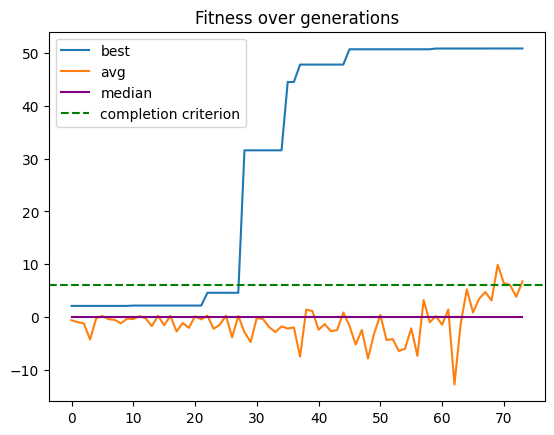

In [6]:
# Plot stats
bests = stats.get_fitness_stat(np.max)
avgs = stats.get_fitness_mean()
medians = stats.get_fitness_median()
stds = stats.get_fitness_stdev()
utils.plot_data(bests, avgs = avgs, medians = medians, 
                completion_fitness=env.n_task * (environment.REWARD_PICK + environment.REWARD_DROP))

Visualize the behaviour of the best individual

In [53]:
calculate_fitnesses([(1, p.best_genome)], config, verbose=True)

. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . . . . . . .
. . . . . . . . O . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .


In [36]:
p.best_genome.fitness

15.0